# Author : Deepanshu Chauhan
## The Sparks Foundation
### Data Science & Business Analyst Intern

### Task 2 - Stock Market Prediction
### #GRIPDECEMBER23 

In [1]:
import os                                                                  
import pandas as pd                                                        
import numpy as np                                                         
import seaborn as sns                                                      
import matplotlib.pyplot as plt                                            

import warnings
warnings.filterwarnings('ignore')

import nltk                                                                 
nltk.downloader.download('vader_lexicon')                                   
import re                                                                   
from textblob import TextBlob                                               
from nltk.sentiment.vader import SentimentIntensityAnalyzer                 
from sklearn.preprocessing import MinMaxScaler                              

from sklearn.metrics import mean_squared_error                              
from sklearn.model_selection import train_test_split                        
import xgboost                          

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\deepa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Importing 

In [2]:
columns=['Date','Category','News']
dataset_news = pd.read_csv(r"C:\Users\deepa\OneDrive\Desktop\GRIP\Stock\india-news-headlines.csv",names=columns)
dataset_news.head()

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [3]:
#**lets drop category column no need it in our work and create a copy from dataset**
dataset_news.drop(0, inplace=True)
dataset_news.drop('Category', axis = 1, inplace=True)
df_news = dataset_news.copy()
df_news.head()

,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic


In [4]:
# Load the second dataset
dataset_price = pd.read_csv(r"C:\Users\deepa\OneDrive\Desktop\GRIP\Stock\AAPL.csv")
df_price = dataset_price.copy()
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600


### Data Preprocessing

In [5]:
#modify date format in 2 dataset
df_news["Date"] = pd.to_datetime(df_news["Date"],format='%Y%m%d')
df_price["Date"]= pd.to_datetime(df_price["Date"])

#removing unwanted characters from the News
df_news.replace("[^a-zA-Z']"," ",regex=True,inplace=True)

In [6]:
df_news.head(2)

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya s...
2,2001-01-02,Fissures in Hurriyat over Pak visit


In [7]:
# Group the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace=True,drop=True)

In [8]:
df_news.head(3)

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...


### Exploratory Data Analysis of News

In [9]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7717 entries, 0 to 7716
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7717 non-null   datetime64[ns]
 1   News    7717 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 120.7+ KB


In [10]:
df_news.describe()

,Date
count,7717
mean,2011-09-06 14:48:13.248671744
min,2001-01-02 00:00:00
25%,2006-05-27 00:00:00
50%,2011-09-07 00:00:00
75%,2016-12-18 00:00:00
max,2022-03-31 00:00:00


In [11]:
print("Number of rows : {}".format(df_news.shape[0]))

Number of rows : 7717


In [12]:
#Check Missing Values
def check_missing(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(20)

check_missing(df_news)

,Total,Percent
Date,0,0.0
News,0,0.0


### Exploratory Data Analysis of Price

In [13]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10825 entries, 0 to 10824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10825 non-null  datetime64[ns]
 1   Open       10825 non-null  float64       
 2   High       10825 non-null  float64       
 3   Low        10825 non-null  float64       
 4   Close      10825 non-null  float64       
 5   Adj Close  10825 non-null  float64       
 6   Volume     10825 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 592.1 KB


In [14]:
df_price.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,10825,10825.000000,10825.000000,10825.000000,10825.000000,10825.000000,1.082500e+04
mean,2002-05-24 02:52:24.055427328,19.610302,19.827766,19.401885,19.623768,18.871210,3.221874e+08
min,1980-12-12 00:00:00,0.049665,0.049665,0.049107,0.049107,0.038000,0.000000e+00
25%,1991-08-27 00:00:00,0.294085,0.301339,0.286830,0.294643,0.240832,1.166932e+08
50%,2002-05-21 00:00:00,0.506696,0.515625,0.500000,0.507813,0.417180,2.096472e+08
75%,2013-02-20 00:00:00,18.749643,18.925714,18.542856,18.749643,16.310215,4.022592e+08
max,2023-11-17 00:00:00,196.240005,198.229996,195.279999,196.449997,195.926956,7.421641e+09
std,NaN,41.058705,41.524041,40.627989,41.097096,40.684457,3.365148e+08


In [15]:
print("Number of rows : {}".format(df_price.shape[0]))

Number of rows : 10825


In [16]:
check_missing(df_price)

,Total,Percent
Date,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Adj Close,0,0.0
Volume,0,0.0


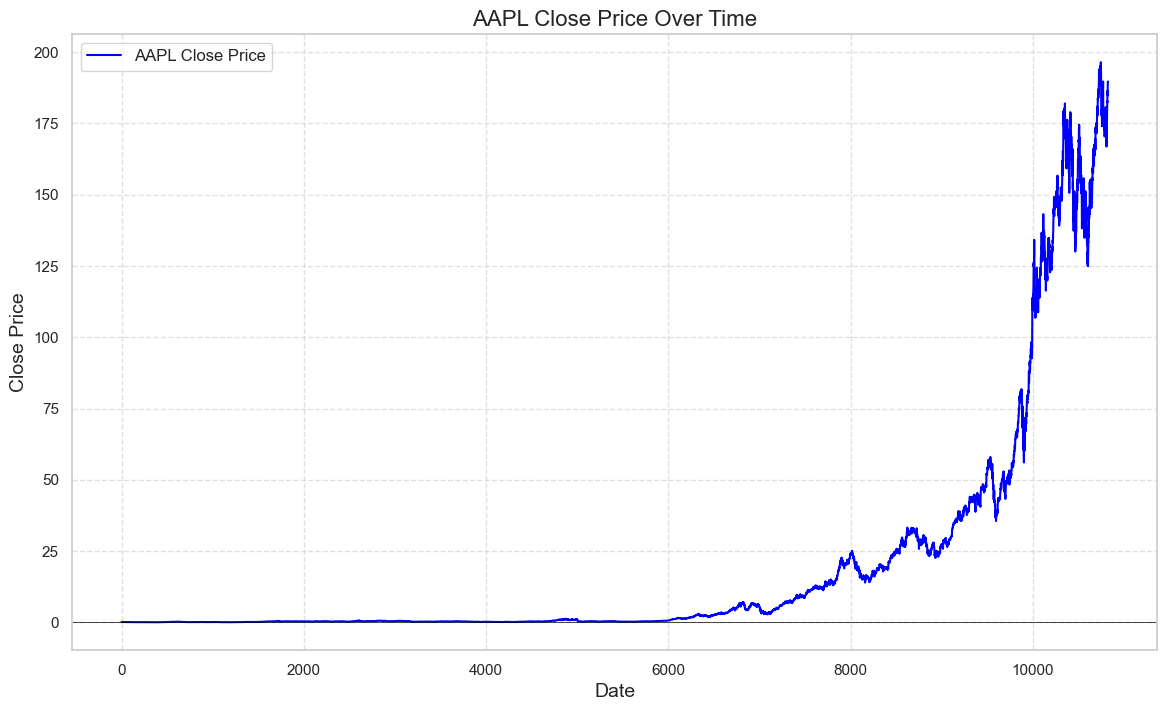

In [32]:
# Figure Plot
sns.set(style="whitegrid")

# Create a figure and axis with specified figsize
plt.figure(figsize=(14, 8))

# Plot the 'Close' column with a line plot
sns.lineplot(data=df_price, x=df_price.index, y='Close', color='blue', label='AAPL Close Price')

# Add labels and title
plt.title('AAPL Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=12)

# Add a horizontal line at zero for better visualization
plt.axhline(0, color='black',linewidth=0.5)

# Show plot
plt.show()

### Textual Analysis

In [18]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
      return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
      return  TextBlob(text).sentiment.polarity

In [19]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954


In [20]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()
df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954,-0.9999,0.156,0.769,0.076


### Combining the Prices and Textual Data

In [21]:
df_merge = pd.merge(df_price, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.225165,452312000,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.247871,817073600,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.258278,739396000,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.247871,412356000,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.250709,373699200,Sangh Parivar Babri panel up the ante Frontru...,0.400343,-0.011266,-0.9779,0.121,0.813,0.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313,2022-03-25,173.880005,175.279999,172.750000,174.720001,172.966339,80546200,Speeding up shortcuts and tackling unruly cus...,0.373221,-0.003922,-1.0000,0.184,0.742,0.074
5314,2022-03-28,172.169998,175.729996,172.000000,175.600006,173.837524,90371900,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
5315,2022-03-29,176.690002,179.009995,176.339996,178.960007,177.163788,100589400,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086
5316,2022-03-30,178.550003,179.610001,176.699997,177.770004,175.985733,92633200,I will not give in to trends Dossmode The tim...,0.344136,0.039954,-0.9999,0.156,0.769,0.076


In [22]:
df_final = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
df_final

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.265625,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,0.292411,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,0.304688,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,0.292411,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,0.295759,0.400343,-0.011266,-0.9779,0.121,0.813,0.066
...,...,...,...,...,...,...,...
5313,174.720001,0.373221,-0.003922,-1.0000,0.184,0.742,0.074
5314,175.600006,0.383007,0.058513,-0.9999,0.160,0.737,0.103
5315,178.960007,0.403627,0.092144,-0.9999,0.159,0.755,0.086
5316,177.770004,0.344136,0.039954,-0.9999,0.156,0.769,0.076


### Normalization

In [23]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df_final))
df_scaled.columns = df_final.columns
df_scaled.index = df_final.index
df_scaled.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.000172,0.286859,0.513986,0.010401,0.272523,0.809,0.116776
1,0.000320,0.392857,0.439935,0.054503,0.351351,0.735,0.179276
2,0.000387,0.445360,0.445054,0.877194,0.234234,0.792,0.171053
3,0.000320,0.480553,0.678214,0.982299,0.319820,0.694,0.269737
4,0.000338,0.400343,0.302819,0.011051,0.272523,0.813,0.108553


### Splitting the data into feature and target

In [24]:
X=df_scaled.drop('Close',axis=1)
y=df_scaled['Close']

### Splitting the data into train and test data

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

### XGBRegressor Model

In [26]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)
predictions = xgb.predict(x_test)

### XGBRegressor Model Performance

In [27]:
print(mean_squared_error(y_test,predictions))

0.02548755444210363


### Confusion Matrix

In [30]:
threshold = 0.5
y_pred_class = np.where(predictions > threshold, 1, 0)
y_test_class = np.where(y_test > threshold,1,0)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[957  29]
 [ 57  21]]


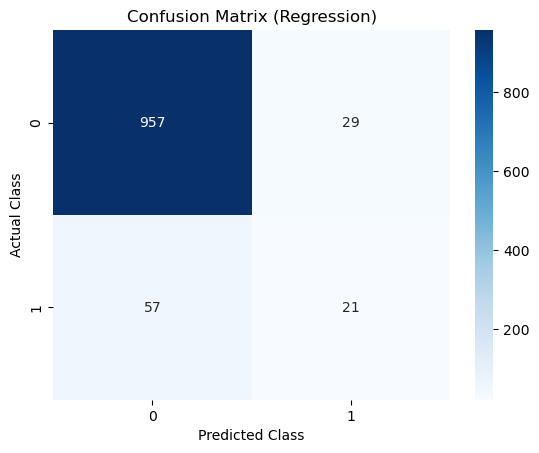

In [31]:
sns.heatmap(confusion_matrix(y_test_class, y_pred_class), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix (Regression)')
plt.show()